# Data Exploration and Treatment

#### Imports and Display of the DataFrame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # Enables IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


data_pwd = "../datasets/btc_options_data/btc_eod_202409.csv"
options_data = pd.read_csv(data_pwd, delimiter = ", ")

options_data

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17728\244697795.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  options_data = pd.read_csv(data_pwd, delimiter = ", ")


,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[INSTRUMENT_NAME],[BASE_CURRENCY],[CONTRACT_SIZE],[UNDERLYING_INDEX],[UNDERLYING_PRICE],[EXPIRY_DATE],...,[ASK_SIZE],[OPEN_INTEREST],[VOLUME],[DELTA],[GAMMA],[VEGA],[THETA],[RHO],[MARK_IV],[STRIKE_DISTANCE_PCT]
0,1725163208,2024-09-01 00:00,2024-09-01,0.0,BTC-1SEP24-53000-C,BTC,1.0,SYN.BTC-1SEP24,58529.2644,2024-09-01,...,70.0,0.0,0.0,1.00000,0.00000,0.00000,-0.00001,0.25108,77.88,0.09446
1,1725163208,2024-09-01 00:00,2024-09-01,0.0,BTC-1SEP24-53000-P,BTC,1.0,SYN.BTC-1SEP24,58529.2644,2024-09-01,...,1.1,50.4,5.0,0.00000,0.00000,0.00000,0.00000,0.00000,77.88,0.09446
2,1725163208,2024-09-01 00:00,2024-09-01,0.0,BTC-1SEP24-54000-C,BTC,1.0,SYN.BTC-1SEP24,58529.2644,2024-09-01,...,70.0,0.0,0.0,1.00000,0.00000,0.00000,-0.00009,0.25171,69.47,0.07738
3,1725163208,2024-09-01 00:00,2024-09-01,0.0,BTC-1SEP24-54000-P,BTC,1.0,SYN.BTC-1SEP24,58529.2644,2024-09-01,...,6.6,6.2,1.3,0.00000,0.00000,0.00002,-0.00004,0.00000,69.47,0.07738
4,1725163208,2024-09-01 00:00,2024-09-01,0.0,BTC-1SEP24-55000-C,BTC,1.0,SYN.BTC-1SEP24,58529.2644,2024-09-01,...,70.0,0.0,0.0,0.99999,0.00000,0.00081,-0.02799,0.25323,69.47,0.06029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26125,1727668803,2024-09-30 00:00,2024-09-30,0.0,BTC-26SEP25-160000-P,BTC,1.0,BTC-26SEP25,70333.3100,2025-09-26,...,7.5,0.0,0.0,-0.82004,0.00001,183.55778,-16.85862,-1492.04662,66.34,1.47841
26126,1727668803,2024-09-30 00:00,2024-09-30,0.0,BTC-26SEP25-180000-C,BTC,1.0,BTC-26SEP25,70333.3100,2025-09-26,...,18.3,0.4,0.0,0.14483,0.00000,159.33836,-14.93227,74.12420,67.69,1.78821
26127,1727668803,2024-09-30 00:00,2024-09-30,0.0,BTC-26SEP25-180000-P,BTC,1.0,SYN.BTC-26SEP25,70859.0300,2025-09-26,...,0.0,0.0,0.0,-0.85056,0.00000,164.79096,-15.28316,-1722.17974,67.69,1.78821
26128,1727668803,2024-09-30 00:00,2024-09-30,0.0,BTC-26SEP25-200000-C,BTC,1.0,BTC-26SEP25,70333.3100,2025-09-26,...,0.1,8.2,0.3,0.11540,0.00000,136.13603,-12.87380,59.77670,68.31,2.09801


From exploring the dataset, we see that the data provider gave some Ask and Bid placeholder values that are not valid (-98.98998). In order to tackle them, I will use Iterative imputing (I've tested KNN and it produces some phishy results).

In [2]:
options_data.columns = options_data.columns.str.strip().str.replace('[', '', regex=True).str.replace(']', '', regex=True)

# Relevant columns
relevant_columns = [
    "UNDERLYING_PRICE",  # Spot price (S)
    "STRIKE",            # Strike price (K)
    "DTE",               # Days to expiration (t)
    "OPTION_RIGHT",      # Call or Put
    "MARK_IV",           # Implied volatility (σ)
    "BID_PRICE",         # Bid price
    "ASK_PRICE",         # Ask price
    "QUOTE_DATE",        # Quotation date
    "EXPIRY_DATE",       # Expiration date
    "DELTA",
    "GAMMA",
    "VEGA",
    "THETA",
    "RHO"
]

# Filter the data with cleaned column names
options_data_cleaned = options_data[relevant_columns].copy()

# Add calculated column for the mid-price
options_data_cleaned['MID_PRICE'] = (options_data_cleaned['BID_PRICE'] + options_data_cleaned['ASK_PRICE']) / 2

options_data_cleaned[options_data_cleaned["OPTION_RIGHT"] == "call"]

options_data_cleaned.describe()


,UNDERLYING_PRICE,STRIKE,DTE,MARK_IV,BID_PRICE,ASK_PRICE,DELTA,GAMMA,VEGA,THETA,RHO,MID_PRICE
count,26130.000000,26130.000000,26130.000000,26130.000000,26130.000000,26130.000000,26130.000000,26130.000000,26130.000000,26130.000000,26130.000000,26130.000000
mean,60919.428178,71206.276311,61.625007,69.322817,0.173027,0.180343,-0.016027,0.000028,43.856209,-34.269299,-42.809348,0.176685
std,3790.692203,40619.854330,77.639442,22.483098,0.330070,0.338711,0.631180,0.000064,51.907644,43.987907,213.463501,0.333749
min,53809.202200,10000.000000,0.166280,23.320000,0.000000,0.000000,-1.000000,0.000000,0.000000,-395.008390,-2450.973090,0.000000
25%,57943.980000,52000.000000,6.166480,56.960000,0.004600,0.005500,-0.532863,0.000000,3.653540,-41.273193,-18.016730,0.005050
50%,60503.430000,62000.000000,30.166670,63.020000,0.052000,0.055000,0.000000,0.000010,23.015175,-22.777720,0.000000,0.053750
75%,64170.630000,76000.000000,90.166640,74.210000,0.202500,0.210000,0.467180,0.000030,69.777890,-7.836510,11.155145,0.207000
max,72009.890000,300000.000000,364.166500,207.400000,4.431000,4.469000,1.000000,0.001180,286.196880,0.000000,305.258000,4.450000


In [3]:
# Check for missing data
missing_data_summary = options_data_cleaned.isnull().sum()
print("Missing Data Summary:")
print(missing_data_summary)

print()

Missing Data Summary:
UNDERLYING_PRICE    0
STRIKE              0
DTE                 0
OPTION_RIGHT        0
MARK_IV             0
BID_PRICE           0
ASK_PRICE           0
QUOTE_DATE          0
EXPIRY_DATE         0
DELTA               0
GAMMA               0
VEGA                0
THETA               0
RHO                 0
MID_PRICE           0
dtype: int64



Making Correlation Matrix and comparing the data before and after imputation.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17728\2901005538.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = options_data_cleaned.corr()


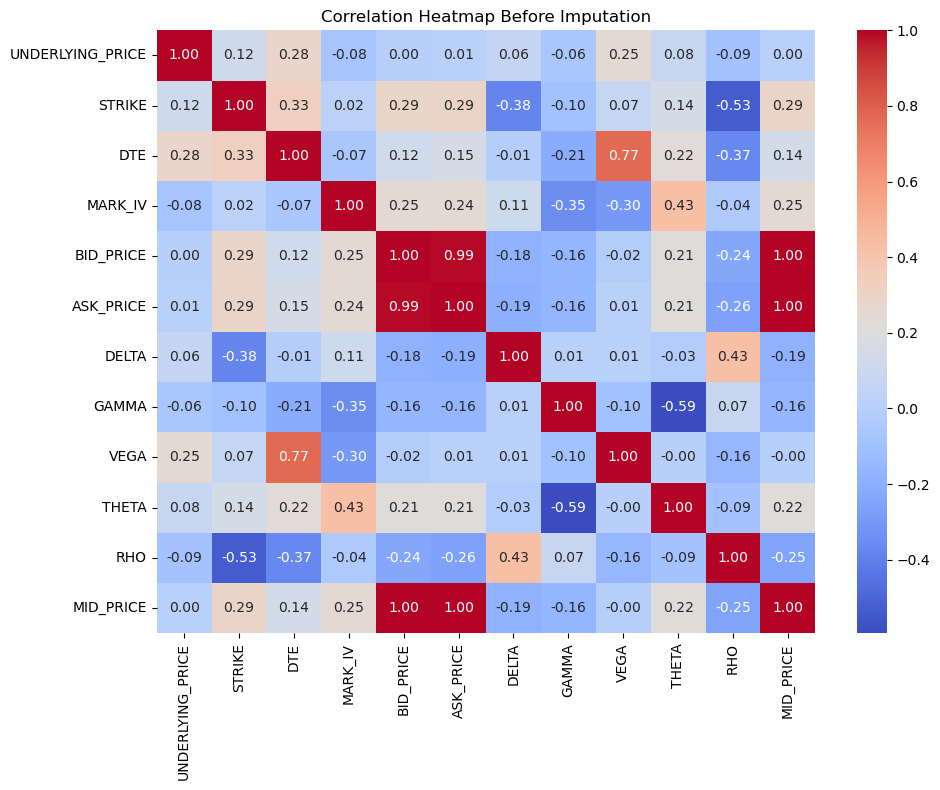

In [4]:
correlation_matrix = options_data_cleaned.corr()

# 1. Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap Before Imputation")
plt.tight_layout()
plt.show()



Now, to further validate the imputation, we check the spreads and their distributions. As a rule of thumb, we want the "Ask" value higher than the "Bid" value for the majority of the data - but not by a lot.

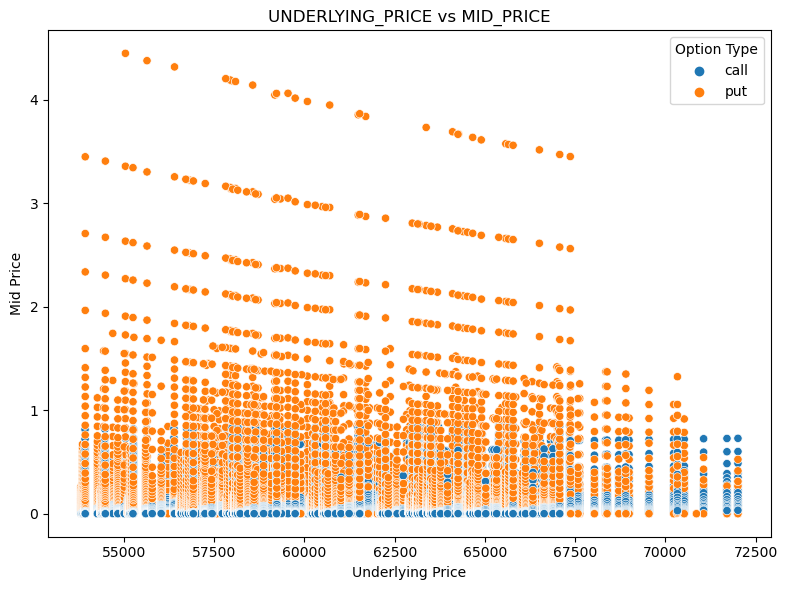

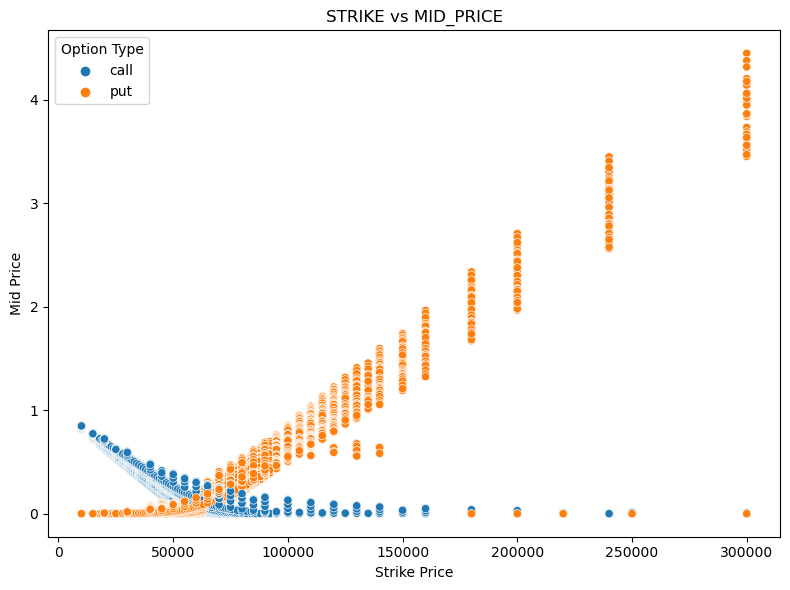

In [5]:
# Scatter plot: UNDERLYING_PRICE vs MID_PRICE
plt.figure(figsize=(8, 6))
sns.scatterplot(data=options_data_cleaned, x="UNDERLYING_PRICE", y="MID_PRICE", hue="OPTION_RIGHT")
plt.title("UNDERLYING_PRICE vs MID_PRICE")
plt.xlabel("Underlying Price")
plt.ylabel("Mid Price")
plt.legend(title="Option Type")
plt.tight_layout()
plt.show()

# Scatter plot: STRIKE vs MID_PRICE
plt.figure(figsize=(8, 6))
sns.scatterplot(data=options_data_cleaned, x="STRIKE", y="MID_PRICE", hue="OPTION_RIGHT")
plt.title("STRIKE vs MID_PRICE")
plt.xlabel("Strike Price")
plt.ylabel("Mid Price")
plt.legend(title="Option Type")
plt.tight_layout()
plt.show()


To finish up our data treatment, we now create a few rows calculating some metrics that will probably be important for our modelling.

In [13]:
# Moneyness
options_data_cleaned['MONEYNESS'] = options_data_cleaned['UNDERLYING_PRICE'] / options_data_cleaned['STRIKE']

# ASK/BID in USD
options_data_cleaned["ASK_USD"] = options_data_cleaned["ASK_PRICE"] * options_data_cleaned["UNDERLYING_PRICE"]
options_data_cleaned["BID_USD"] = options_data_cleaned["BID_PRICE"] * options_data_cleaned["UNDERLYING_PRICE"]

# Negotiated Price
options_data_cleaned["NEGOTIATED_PRICE"] = (options_data_cleaned["ASK_USD"] + options_data_cleaned["BID_USD"]) / 2


Saving the data into the datasets folder:

In [14]:
import os

# Ensure the output folder exists
output_folder = "../datasets/btc_options_data"
os.makedirs(output_folder, exist_ok=True)

# Separate datasets by Call/Put
calls = options_data_cleaned[options_data_cleaned['OPTION_RIGHT'].str.lower() == 'call']
puts = options_data_cleaned[options_data_cleaned['OPTION_RIGHT'].str.lower() == 'put']

# Save datasets to CSV files in the same folder
calls.to_csv(f"{output_folder}/european_btc_calls.csv", index=False)
puts.to_csv(f"{output_folder}/european_btc_puts.csv", index=False)

# Verify the files were saved
saved_files = os.listdir(output_folder)
print("Saved files:", saved_files)




Saved files: ['btc_eod_202409.csv', 'btc_sample.csv', 'european_btc_calls.csv', 'european_btc_puts.csv']
